In [14]:
from dataloader import load_parquet
#THIS_PATH = os.path.dirname(os.path.realpath(__file__))
MY_FILE = "aisdk-2025-02-27"

http://aisdata.ais.dk/!_README_information_CSV_files.txt

SOG =  Speed over ground from AIS message if available

COG = Course over ground from AIS message if available

Segment = Divide track into segments based on timegap (he created this in a script)
"Copilot explanation: " Segment splits a vessel's time-ordered AIS track into contiguous sub-tracks whenever there's a large time gap between consecutive messages. This prevents treating long gaps (e.g., device off, no reception) as part of the same continuous trajector""

MMSI = Marinetime Mobile Service Identity (unique 9 digit identifier)

In [15]:
# Exploration imports and load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataloader import load_parquet

plt.rcParams['figure.figsize'] = (10, 5)

MY_FILE = "aisdk-2025-02-27"
# load a sample of data (k controls number of MMSIs sampled by load_parquet)
df = load_parquet(MY_FILE, k=1000)
print('Loaded rows,cols:', df.shape)
df.head()

Loaded rows,cols: (5044504, 9)


,Timestamp,Latitude,Longitude,SOG,COG,Segment,MMSI,x,y
0,2025-02-27 00:00:05,56.123522,11.591552,6.739216,90.1,0,MMSI=200000000,1.290366e+06,7.583045e+06
1,2025-02-27 00:00:06,56.123522,11.591770,6.739216,90.0,0,MMSI=200000000,1.290390e+06,7.583045e+06
2,2025-02-27 00:00:07,56.123522,11.591770,6.739216,90.0,0,MMSI=200000000,1.290390e+06,7.583045e+06
3,2025-02-27 00:00:13,56.123518,11.592530,6.739216,89.8,0,MMSI=200000000,1.290475e+06,7.583044e+06
4,2025-02-27 00:00:14,56.123518,11.592637,6.739216,89.7,0,MMSI=200000000,1.290486e+06,7.583044e+06


In [16]:
# Quick dataset overview
print('\n--- dtypes and non-null counts ---')
df.info()
print('\n--- missing values per column ---')
print(df.isna().sum())

print('\nUnique MMSIs:', df['MMSI'].nunique())
print('Unique Segments:', df[['MMSI','Segment']].drop_duplicates().shape[0])


--- dtypes and non-null counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044504 entries, 0 to 5044503
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Timestamp  datetime64[ns]
 1   Latitude   float64       
 2   Longitude  float64       
 3   SOG        float64       
 4   COG        float64       
 5   Segment    int32         
 6   MMSI       object        
 7   x          float64       
 8   y          float64       
dtypes: datetime64[ns](1), float64(6), int32(1), object(1)
memory usage: 327.1+ MB

--- missing values per column ---
Timestamp         0
Latitude          0
Longitude         0
SOG            7959
COG          150331
Segment           0
MMSI              0
x                 0
y                 0
dtype: int64

Unique MMSIs: 1000

Unique MMSIs: 1000
Unique Segments: 1187
Unique Segments: 1187


Total MMSIs: 1000

Top 20 MMSIs by number of records:
MMSI
MMSI=257339000    26306
MMSI=219313000    22906
MMSI=200000000    22541
MMSI=219027298    21479
MMSI=219022903    19792
MMSI=219018172    19061
MMSI=219000604    18999
MMSI=219017081    17050
MMSI=219006092    17023
MMSI=219017895    16532
MMSI=220135000    16127
MMSI=246184000    15155
MMSI=219024178    14965
MMSI=219023648    14658
MMSI=215195000    14595
MMSI=636023238    13988
MMSI=219429000    13843
MMSI=265859000    13842
MMSI=219024784    13829
MMSI=246774000    13720
Name: count, dtype: int64


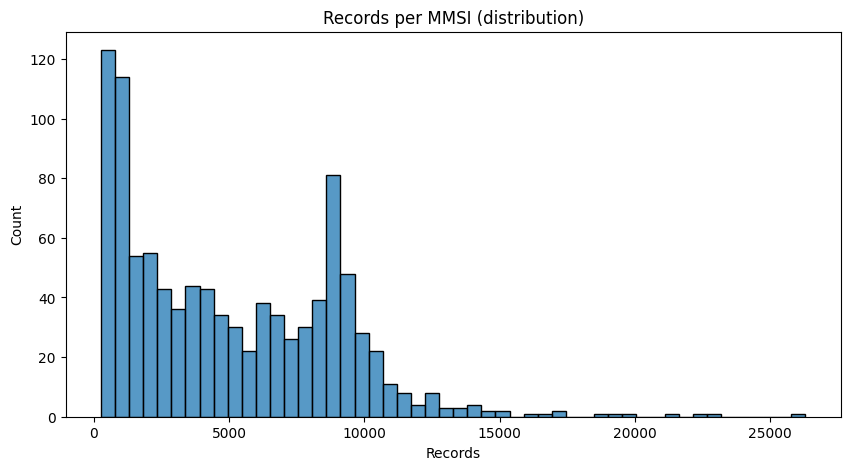

In [17]:
# MMSI frequency and top vessels
mmsi_counts = df['MMSI'].value_counts()
print('Total MMSIs:', len(mmsi_counts))
print('\nTop 20 MMSIs by number of records:')
print(mmsi_counts.head(20))

# Plot distribution of records per MMSI
sns.histplot(mmsi_counts, bins=50)
plt.title('Records per MMSI (distribution)')
plt.xlabel('Records')
plt.show()

Segments total: 1187


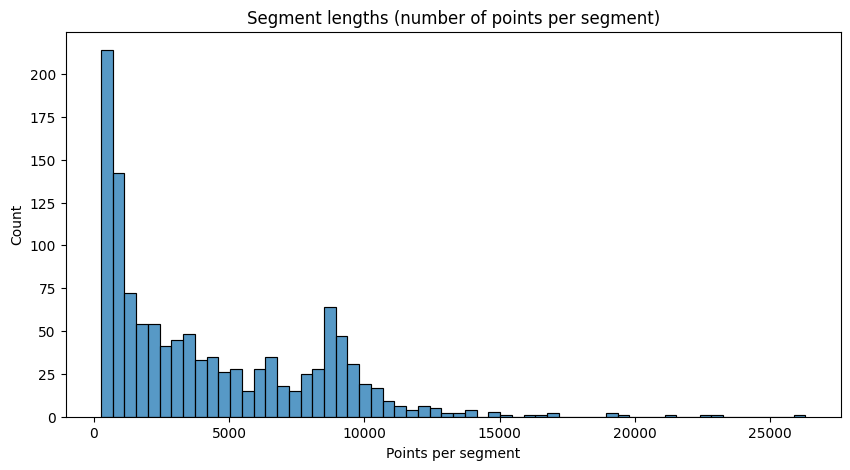

In [18]:
# Segment length distribution (points per segment)
seg_len = df.groupby(['MMSI','Segment']).size().reset_index(name='n')
print('Segments total:', len(seg_len))
seg_len['n'].describe()

sns.histplot(seg_len['n'], bins=60)
plt.title('Segment lengths (number of points per segment)')
plt.xlabel('Points per segment')
plt.show()

Time range: 2025-02-27 00:00:00 to 2025-02-27 23:59:58
 2025-02-27 00:00:00 to 2025-02-27 23:59:58


c:\Users\veron\AppData\Local\pypoetry\Cache\virtualenvs\deeplearning-GoYQu1Km-py3.12\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


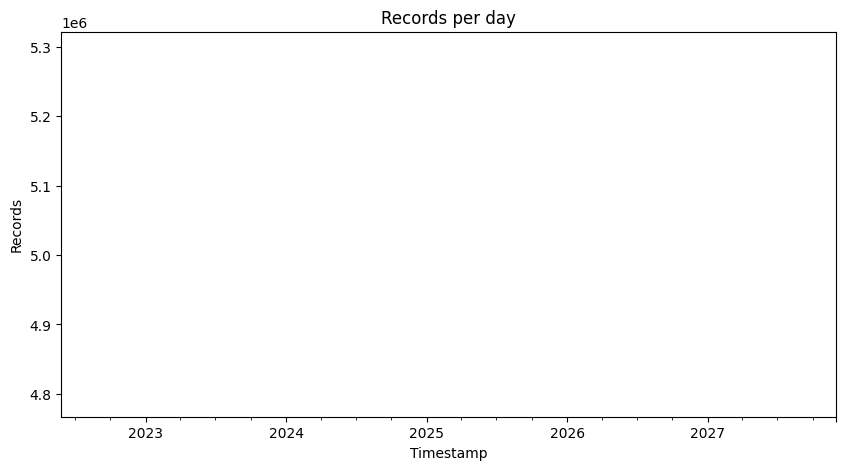

In [19]:
# Time coverage and records per day
# ensure Timestamp is datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
print('Time range:', df['Timestamp'].min(), 'to', df['Timestamp'].max())

# records per day
daily = df.set_index('Timestamp').resample('D').size()
daily.plot()
plt.title('Records per day')
plt.ylabel('Records')
plt.show()

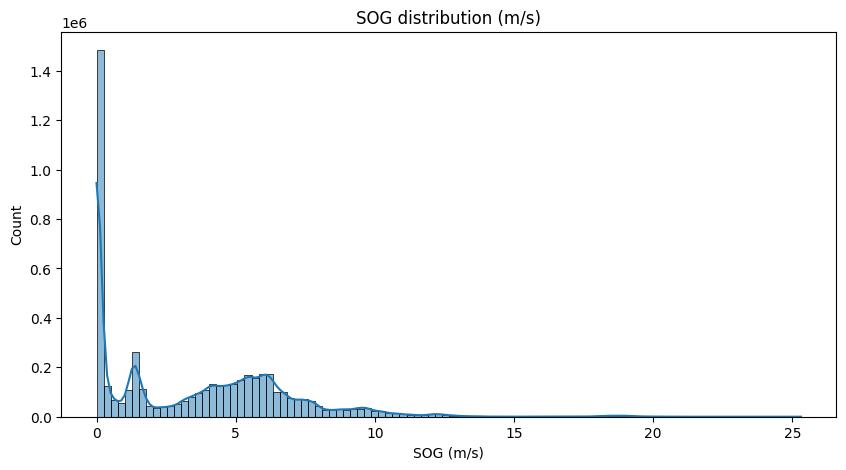

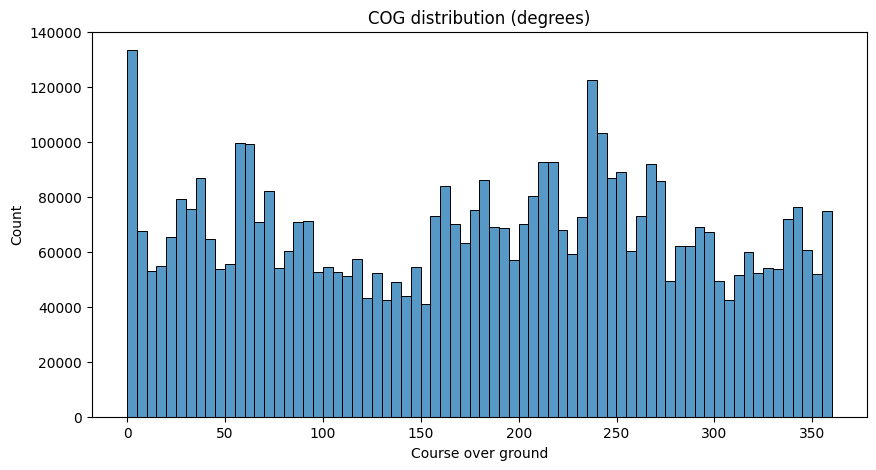

In [20]:
# SOG and COG distributions
sns.histplot(df['SOG'].dropna(), bins=100, kde=True)
plt.title('SOG distribution (m/s)')
plt.xlabel('SOG (m/s)')
plt.show()

sns.histplot(df['COG'].dropna(), bins=72)
plt.title('COG distribution (degrees)')
plt.xlabel('Course over ground')
plt.show()

Sample MMSIs: ['MMSI=257339000', 'MMSI=219313000', 'MMSI=200000000', 'MMSI=219027298', 'MMSI=219022903']


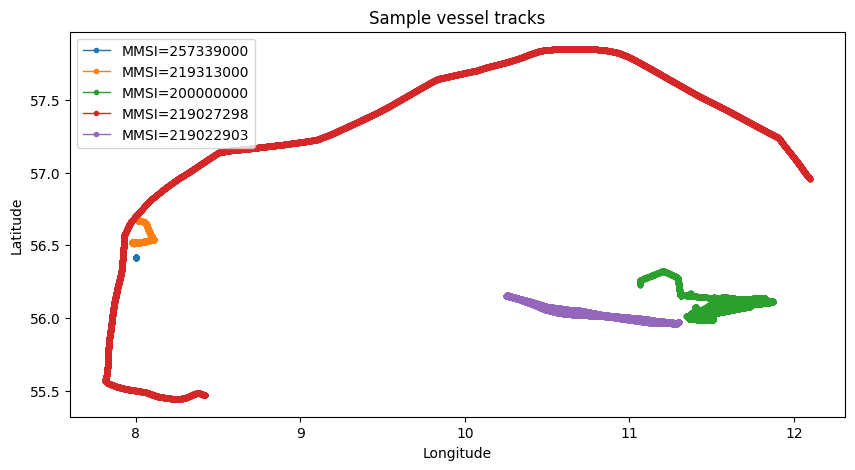

In [21]:
# Map: sample some MMSIs and plot tracks
sample_mmsis = df['MMSI'].value_counts().head(5).index.tolist()
print('Sample MMSIs:', sample_mmsis)

fig, ax = plt.subplots()
for m in sample_mmsis:
    sub = df[df['MMSI']==m].sort_values('Timestamp')
    ax.plot(sub['Longitude'], sub['Latitude'], marker='.', linewidth=1, label=str(m))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Sample vessel tracks')
ax.legend()
plt.show()

In [22]:
# Save cleaned sample for modelling (optional)
# Keep these columns and a sample of segments with at least N points
keep_cols = ['MMSI','Segment','Timestamp','Longitude','Latitude','SOG','COG']
seg_len = df.groupby(['MMSI','Segment']).size().reset_index(name='n')
keep_segments = seg_len[seg_len['n']>=100][['MMSI','Segment']]
keep_df = df.merge(keep_segments, on=['MMSI','Segment'], how='inner')
print('Kept rows for modelling:', keep_df.shape)
# write to a local parquet sample
keep_df.to_parquet('sample_for_modeling.parquet', index=False)
print('Wrote sample_for_modeling.parquet')

Kept rows for modelling: (5044504, 9)
Wrote sample_for_modeling.parquet
Wrote sample_for_modeling.parquet
